In [1]:
import grasp2alm as g2a
import numpy as np
import healpy as hp
import math
import os
import matplotlib.pyplot as plt
from math import factorial

In [2]:
pol = True
nside: int = 1024
lmax: int = 2*nside
beam_fwhm_deg = np.rad2deg(hp.nside2resol(nside))*100
beam_fwhm = np.deg2rad(beam_fwhm_deg)
beam_sigma = beam_fwhm/np.sqrt(8.0*np.log(2.0))
amplitude = 1/(2*np.pi*beam_sigma*beam_sigma)
bias = 0.0

In [3]:
vini: float = -beam_fwhm_deg*3
vnum = 30001
vinc: float = abs(vini)*2/vnum
c = 0
ncut = 40
header_1: str = "Field data in cuts"
header_2 = f"{vini} {vinc} {vnum} {c} 3 1 2"

theta = np.linspace(vini, -vini, vnum)
theta = np.deg2rad(theta)

phi = np.linspace(0, 180-180/ncut, ncut)

In [4]:
def my_gauss(amplitude, sigma, theta, bias = 0.0):
    return amplitude * np.exp(- theta**2 / (2*sigma**2)) + bias

In [5]:
with open('prova.cut', 'w') as file:
    for n in range(ncut):
        file.write(header_1)
        file.write('\n')
        file.write(header_2)
        file.write('\n')
        for i in range(vnum):
            co_i = np.emath.sqrt(my_gauss(amplitude, beam_sigma, theta[i], bias))
            cx_i = 0.0
            file.write(f"{np.real(co_i)} {np.imag(co_i)} {np.real(cx_i)} {np.imag(cx_i)}\n")

In [6]:
if os.path.exists('prova.cut'):
    cut = g2a.BeamCut('prova.cut')
    os.remove('prova.cut')

In [7]:
outOftheta_val = hp.UNSEEN
cpolar = cut.to_polar(copol_axis="y")

In [8]:
cmap = cpolar.to_map(nside, outOftheta_val=outOftheta_val, interp_method='linear')

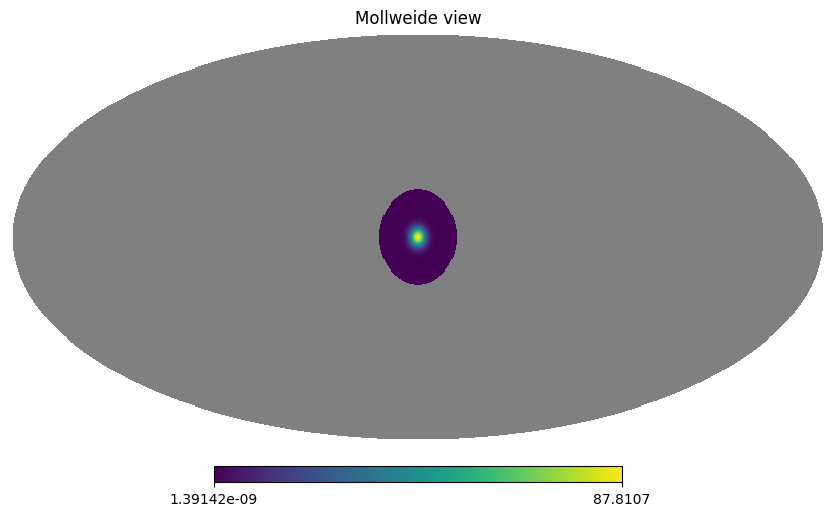

In [9]:
hp.mollview(cmap.map[0], rot=[0,90])

In [10]:
#calm = cmap.to_alm_lsq(lmax=lmax, mmax=2)[0]
calm = cmap.to_alm(lmax=lmax, mmax=2, use_weights=True)
W_I = np.array([calm[0,i]*np.sqrt((4*np.pi)/(2*i+1)) for i in range(lmax)])


# Compare against theoric window function

In [11]:
from scipy.special import ive

def ideal_baeam_window(amplitude, sigma, l):
    alpha = 1/sigma**2
    k = np.sqrt(np.pi/(2*alpha))
    return 4*np.pi*amplitude*k*ive(l+0.5, alpha)

In [12]:
ideal_window = [ideal_baeam_window(amplitude, beam_sigma, i) for i in np.array(range(lmax))]

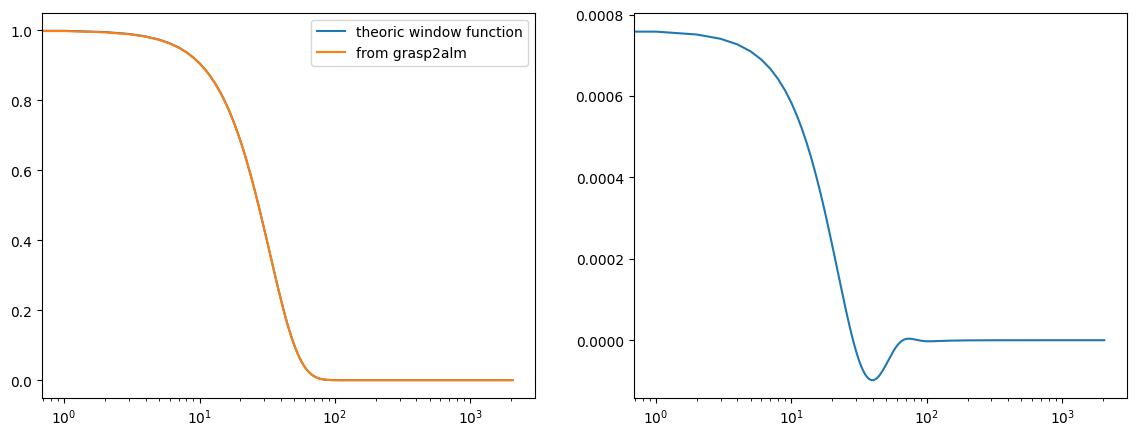

In [13]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].plot(ideal_window, label='theoric window function')
axs[0].plot(abs(W_I), label='from grasp2alm')
axs[0].set_xscale("log")
axs[0].legend()

axs[1].plot(ideal_window-abs(W_I))
axs[1].set_xscale('log')

In [14]:
def ideal_baeam_window_2(amplitude, sigma, l):
    N2_l = 2*factorial(l-2)/factorial(l+2)
    alpha = 1/sigma**2
    c = np.sqrt(np.pi/(2*alpha))
    k1 = 2*(-1)**l*((l+2)*(l-1)+6*alpha)*np.exp(-2*alpha)
    k2 = ((l**2-4*alpha)*(l-1)**2 + 12*alpha)*c*ive(n+0.5, alpha)
    k3 = 4*alpha*(l**2+l+1-3*alpha)*c*ive(n-0.5,alpha)
    return 2*np.pi*amplitude*N2_l*(k1+k2+k3)

# Compare against healpy blm_gauss

In [15]:
from scipy.special import iv,ive

def my_blm_gauss(fwhm:float, lmax:int, pol:bool=False):
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(0, lmax + 1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = \
            np.sqrt((2 * l + 1) / (4.0 * np.pi)) * \
            np.exp(-0.5 * sigmasq * l * (l + 1))

    if pol:
        for l in range(2, lmax + 1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = \
                np.sqrt((2 * l + 1) / (32 * np.pi)) * \
                np.exp(-0.5 * sigmasq * l * (l+1))
        blm[2] = 1j * blm[1]

    # Adjust normalization

    blm[1] = -blm[1] * np.sqrt(2.0)
    blm[2] = -blm[2] * np.sqrt(2.0)

    return blm

In [16]:
blm=hp.blm_gauss(beam_fwhm, lmax=lmax, pol=pol)
blm=my_blm_gauss(beam_fwhm, lmax=lmax, pol=pol)

In [17]:
index_0 = hp.Alm.getidx(lmax, np.arange(lmax), 0)
index_2 = hp.Alm.getidx(lmax, np.arange(lmax), 2)
indexes = [index_0, index_2, index_2]

In [18]:
alm_T_0_yusuke = calm[0][index_0]
alm_E_2_yusuke = calm[1][index_2]
alm_B_2_yusuke = calm[2][index_2]
alm_yusuke = np.array([alm_T_0_yusuke, alm_E_2_yusuke, alm_B_2_yusuke])

alm_T_0_hp = blm[0][index_0]
alm_E_2_hp = blm[1][index_2]
alm_B_2_hp = blm[2][index_2]
alm_hp = np.array([alm_T_0_hp, alm_E_2_hp, alm_B_2_hp])

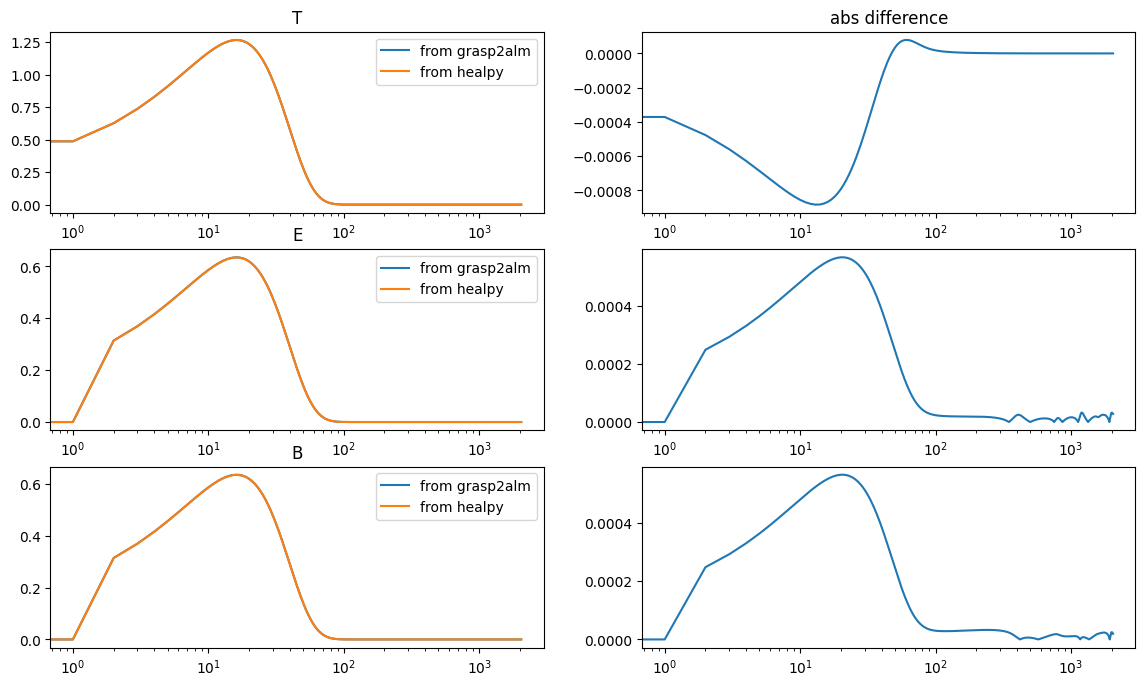

In [19]:
fig, axs = plt.subplots(3,2, figsize=(14,8))
for indx, stokes in enumerate('TEB'):
    axs[indx,0].plot(abs(alm_yusuke[indx]), label='from grasp2alm')
    axs[indx,0].plot(abs(alm_hp[indx]), label='from healpy')
    axs[indx,0].set_title(stokes)
    axs[indx,0].legend()

    axs[0,1].set_title('abs difference')
    axs[indx,1].plot(abs(alm_yusuke[indx])-abs(alm_hp[indx]))

    axs[indx,0].set_xscale('log')
    axs[indx,1].set_xscale('log')

In [20]:
np.allclose(alm_yusuke[0], alm_hp[0], atol=1e-3)

True

In [21]:
np.allclose(alm_yusuke[1], alm_hp[1], atol=1e-3)

True

In [22]:
np.allclose(alm_yusuke[2], alm_hp[2], atol=1e-3)

True

# Check reconstructed maps

In [23]:
m_g2a = hp.alm2map(calm, lmax=lmax, mmax=2 if pol else 0, nside=nside, pol=pol)
m_hp = hp.alm2map(blm, lmax=lmax, mmax=2 if pol else 0, nside=nside, pol=pol)

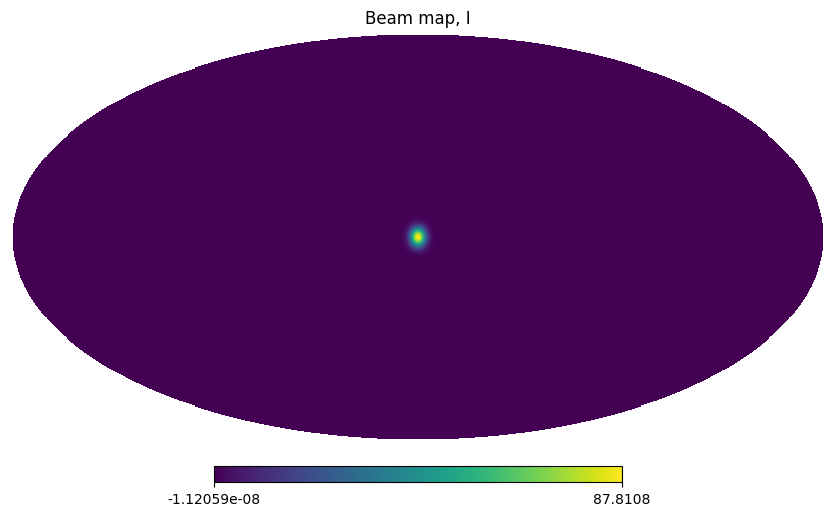

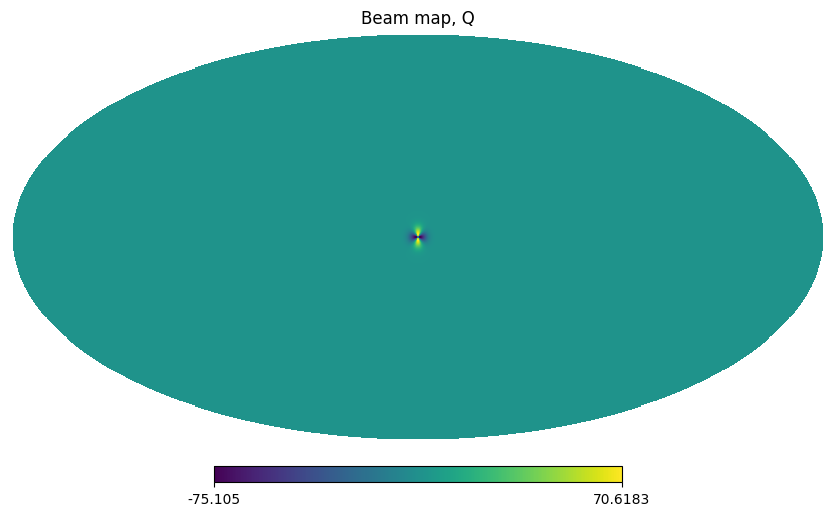

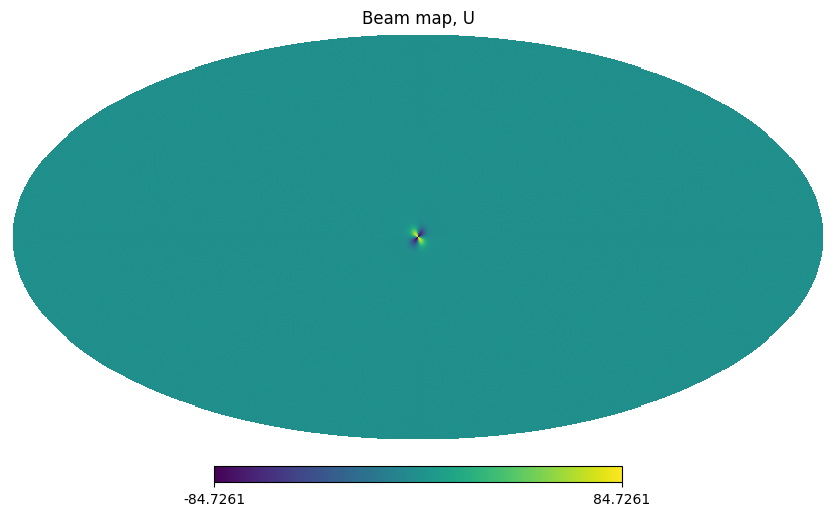

In [24]:
for each_m, label in zip(m_g2a, "IQU"):
    hp.mollview(each_m, rot=[0, 90], title=f"Beam map, {label}")

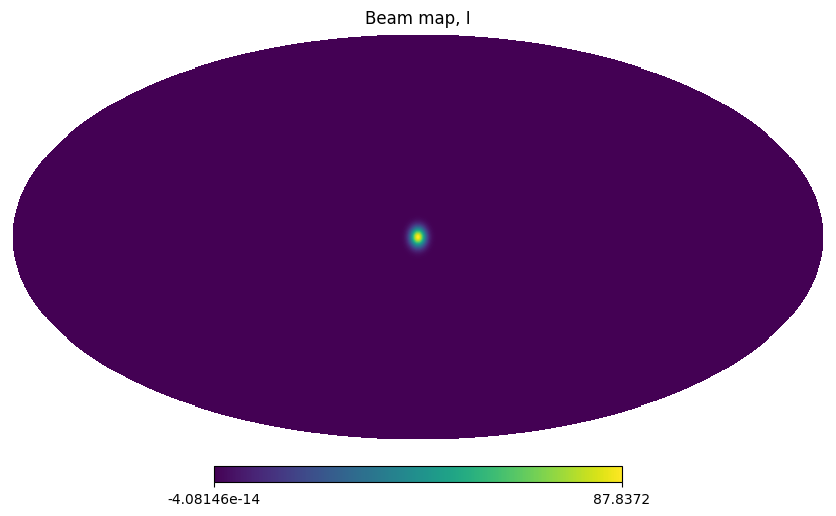

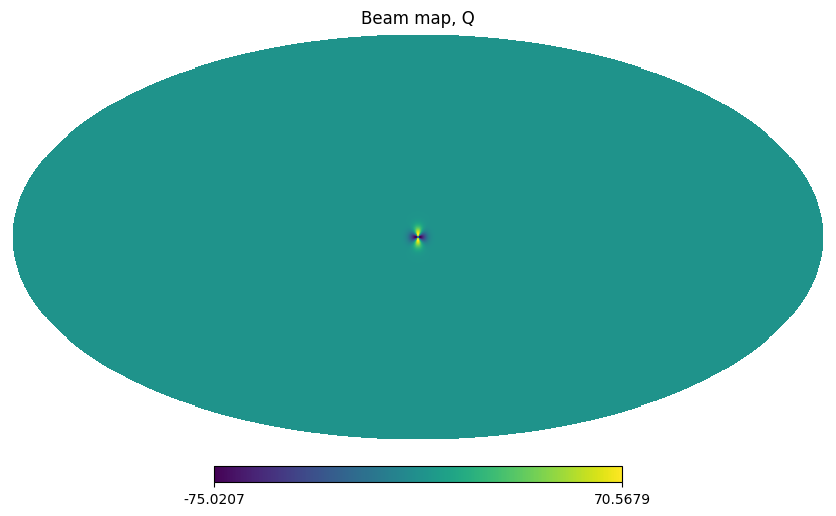

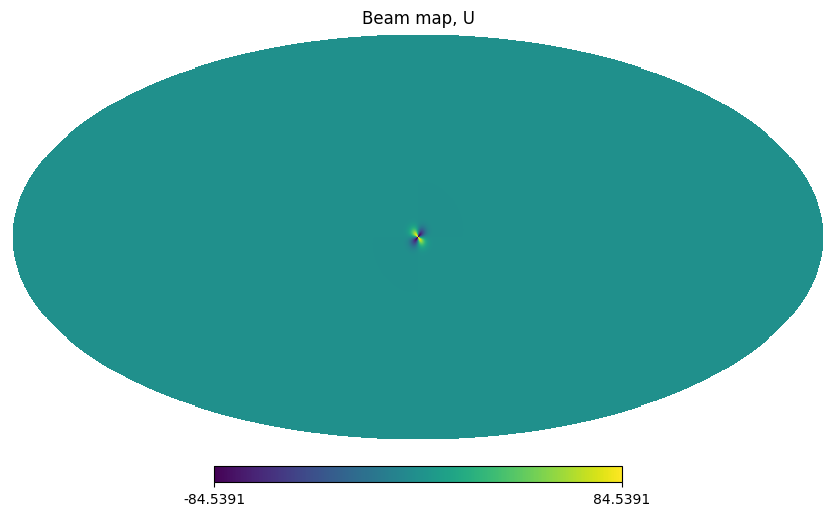

In [25]:
for each_m, label in zip(m_hp, "IQU"):
    hp.mollview(each_m, rot=[0, 90], title=f"Beam map, {label}")